### 1. Используя библиотеку Natasha извлечь все фамильно-именные группы из текстов новостей. 
### 2. Построить граф социальной сети для лиц, упоминавшихся в новостях, считая, что два лица, встретившиеся в одной заметке связаны между собой. 
### 3. Рассчитать меру связности для вершин графа, выделить 10 вершин с самой большой мерой связности.

In [75]:
from bs4 import BeautifulSoup 
from urllib.request import urlopen
import re
import time

In [7]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np

In [10]:
url = 'http://vpered-balezino.ru'
html_doc = urlopen(url).read()
soup = BeautifulSoup(html_doc, 'html.parser')

Дальше нужно достать все ссылки. 
1. Идем по главной по всем страницам
2. На каждой странице достаем ссылки новостей

In [96]:
def find_href(mas_text):
    links_news = []
    for link in mas_text:
        link = str(link)
        regex = r"\"http:(.+)\""
        matches = re.search(regex, link)
        res = matches.group(0)
        res = res.replace("\"", "")
        if res != 'http://vpered-balezino.ru/category/vesti/':
            links_news.append(res)
    return links_news

In [97]:
def max_page():
    pages = []
    maxi = 0
    link = soup.find_all("a", attrs={"class": "page-numbers"})
    for a in link:
        a = str(a)
        regex = r"\d+"
        matches = re.search(regex, a)
        res = matches.group(0)
        pages.append(int(res))
    for page in pages:
        if page>maxi:
            maxi = page
    return maxi

In [98]:
links = []
i = 1 #номер первой страницы
j = max_page() #достаем номер максимальной страницы
while i<=j:
    link = soup.find_all("div", attrs={"class": "td-read-more"})
    links.extend(find_href(link))
    url = 'http://vpered-balezino.ru/page/' + str(i)+'/'
    html_doc = urlopen(url).read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    i = i+1

Формат выгрузки данных:

1. ===== 
2. URL
3. Название источника
4. Дата
5. Автор
6. Название статьи
7. Текст статьи


In [129]:
def writing_in_file(url):
    html_doc = urlopen(url).read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    #название источника
    nazvanie_ist = 'Название источника: газета "Вперед"'
    #ищем дату
    link = soup.find_all("time", attrs={"class": "entry-date updated td-module-date"}, limit=1)
    link = str(link[0])
    regex = r"\d\d\.\d\d\.\d\d\d\d"
    matches = re.search(regex, link)
    try:
        data = matches.group(0)
    except:
        data = 'None'
    #автор везде один стоит
    author = 'газета "Вперед"'
    #ищем название статьи
    link = soup.find_all("h1", attrs={"class": "entry-title"})
    regex = r">(.+)<"
    matches = re.search(regex, str(link))
    try:
        res = matches.group(0)
        res = res.replace(">", "")
        nazvanie_st = res.replace("<", "")
    except:
        nazvanie_st = 'None'
    #достаем текст статьи
    link = soup.find_all("div", attrs={"class": "td-post-content td-pb-padding-side"})
    regex = r">(.+)<"
    text = re.findall(regex, str(link))
    text_f = ' '.join(text)
    text_final = re.sub(r'(\<(/?[^>]+)>)', '', text_f)
    with open('Articles.txt','a') as f:
        f.write('=====' + '\n'+
               'URL: ' + str(url) + '\n' +
                'Название источника: ' + nazvanie_ist + '\n' +
                'Дата: ' + data + '\n' +
                'Автор: ' + author + '\n' +
                'Название статьи: ' + nazvanie_st + '\n' +
                'Текст статьи: ' + text_final + '\n')
                

In [130]:
%%time
writing_in_file(links[0])

CPU times: user 42.6 ms, sys: 3.48 ms, total: 46.1 ms
Wall time: 1.03 s


In [131]:
i = 0
for link in links:
    writing_in_file(link)
    i += 1
    if i % 30 == 0:
        time.sleep(10)

In [2]:
text_news = []
with open("Articles.txt", encoding="utf-8") as f: # Файл с новостями.
    text = f.read()
text = text.split('=====')
for each in text:
    text_news.append(each.split('\n'))
text_news = text_news[1:]

In [73]:
def NER_it(text):
    doc = Doc(text)

    segmenter = Segmenter()
    morph_vocab = MorphVocab()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    syntax_parser = NewsSyntaxParser(emb)
    ner_tagger = NewsNERTagger(emb)
    
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    
    for s in doc.spans:
        s.tokens[-1].lemmatize(morph_vocab)
    return [(s.tokens[-1].lemma, s.type) for s in doc.spans]

def getPolitics(lenta):
    names = {} # имена людей
    connect = {} # с кем связаны
    for art in tqdm(lenta): # берем по статье
        nfacts = NER_it(art[6]) # достаем именные группы
        nam = [fact[0].split(" ")[-1] for fact in nfacts if fact[1]=='PER']
        snam = list(set(nam)) # оставляем только уникальных (убираем повторы)
        for n in snam:
            names[n] = names.get(n, 0)+1
            pers = connect.get(n, {})
            for n2 in snam:
                if n != n2:
                    pers[n2] = pers.get(n2, 0)+1
            connect[n] = pers
    return names, connect

In [74]:
names, connections = getPolitics(text_news)

100%|██████████| 4396/4396 [1:29:57<00:00,  1.23s/it]     


In [81]:
pers2 = {n:{n2:connections[n][n2] for n2 in connections[n].keys() if names[n2]>20 and n2!='.'}
           for n in connections.keys() if names[n]>20 and n!='.'}

In [77]:
def formASocialGraph(persons):
    G=nx.Graph() # создали граф
    for n in persons.keys(): # берем всех личностей
        for n2 in persons[n].keys():
            G.add_edge(n, n2) # добавляем дугу к графу
    return G

In [78]:
G1 = formASocialGraph(pers2)

In [188]:
def drawASocialGraph(G, persons, minimum, colors='b', layout='spring'):
    pstn = nx.spring_layout(G)
    # Размер вершины зависит от того, входит ли вершина в топ-10 по мере связности.
    sz = []
    a = 7
    for n in G.nodes:
        if G.degree[n] >=minimum:
            sz.append(G.degree[n])
        else:
            sz.append(a)
    # Толщина линии дуги зависит от логарифма частоты совместной встречаемости участников новости.
    lw = [math.log(persons[e[0]][e[1]], 10)+1 for e in G.edges]
    nx.draw(G, pos=pstn, node_color=colors, edge_color='g', with_labels=True, node_size=sz, width=lw)

In [189]:
# посчитаем у кого наибольшая мера связности
list_degree = list(degree)
list_degree.sort(key=lambda i: i[1])
most_popular = list_degree[-10:]
minimum = most_popular[0][1]

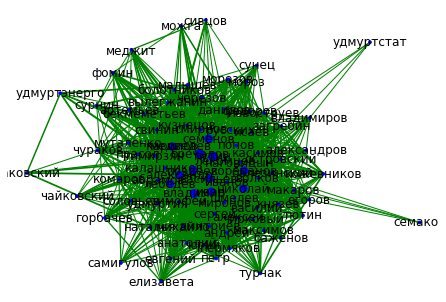

In [190]:
drawASocialGraph(G1, pers2, minimum)